In [1]:
import backtrader as bt
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import enum
import argparse

Loglevel = enum.Enum('Loglevel', 'debug info notice warn error')

class ChartCSVData(bt.feeds.GenericCSVData):
    params = (
        ('dtformat', '%Y-%m-%d %H:%M:%S'),
        ('openinterest', -1),
    )

class CommInfo_Fut_Discount(bt.CommInfoBase):
    params = (
      ('leverage', 25.0),
    )

class FixedSize(bt.Sizer):
    params = (('stake', 50000),) # Trade Unit
    
    def _getsizing(self, comminfo, cash, data, isbuy):
        return self.params.stake

In [2]:
# Create a Stratey
class TestStrategy(bt.SignalStrategy):
    params = (
        ('is_print_sma', False),
        ('maperiod', 15),
        ('loglevel', Loglevel.info),
        ('short', 5 * 60 * 24),
        ('middle', 21 * 60 * 24),
        ('long', 89 * 60 * 24),
        ('sizer', FixedSize())
    )
    
    def log(self, txt, dt=None, level=Loglevel.debug):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        if level.value >= self.params.loglevel.value:
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        if self.p.sizer is not None:
            self.sizer = self.p.sizer
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None
        
        if self.params.is_print_sma:
            # Add a MovingAverageSimple indicator
            sma1 = bt.ind.SMA(period=self.p.short)
            sma2 = bt.ind.SMA(period=self.p.middle)
            sma3 = bt.ind.SMA(period=self.p.long)

    def notify(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price, level=Loglevel.info)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price, level=Loglevel.info)

            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0], level=Loglevel.info)

                        # Keep track of the created order to avoid a 2nd order
                        #self.order = self.buy(size=self.params.size)
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0], level=Loglevel.info)

                # Keep track of the created order to avoid a 2nd order
                #self.order = self.sell(size=self.params.size)
                self.order = self.sell()


Starting Portfolio Value: 1000000.00
2005-01-10, BUY CREATE, 104.78
2005-01-11, BUY EXECUTED, 104.19
2005-01-11, SELL CREATE, 104.17
2005-01-12, SELL EXECUTED, 103.35
2005-01-12, BUY CREATE, 103.36
2005-01-13, BUY EXECUTED, 102.37
2005-01-13, SELL CREATE, 102.37
2005-01-14, SELL EXECUTED, 102.38
2005-01-14, BUY CREATE, 102.36
2005-01-17, BUY EXECUTED, 101.99
2005-01-17, SELL CREATE, 101.97
2005-01-18, SELL EXECUTED, 102.11
2005-01-18, BUY CREATE, 102.08
2005-01-19, BUY EXECUTED, 102.26
2005-01-19, SELL CREATE, 102.25
2005-01-20, SELL EXECUTED, 102.77
2005-01-20, BUY CREATE, 102.79
2005-01-21, BUY EXECUTED, 103.31
2005-01-21, SELL CREATE, 103.32
2005-01-24, SELL EXECUTED, 102.75
2005-01-24, BUY CREATE, 102.80
2005-01-25, BUY EXECUTED, 102.60
2005-01-25, SELL CREATE, 102.60
2005-01-26, SELL EXECUTED, 104.07
2005-01-26, BUY CREATE, 104.03
2005-01-27, BUY EXECUTED, 103.00
2005-01-27, SELL CREATE, 102.96
2005-01-28, SELL EXECUTED, 103.09
2005-01-28, BUY CREATE, 103.12
2005-01-31, BUY EXECUT

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


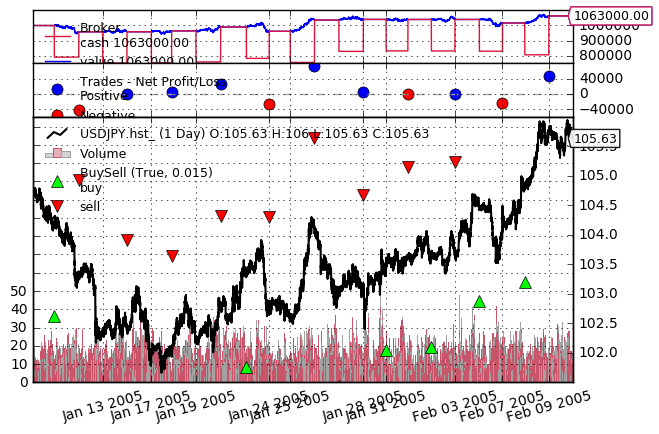

Final Portfolio Value: 1063000.00


In [3]:
if __name__ == '__main__':
    cerebro = bt.Cerebro()
    
    # https://www.backtrader.com/docu/user-defined-commissions/commission-schemes-subclassing.html?highlight=comminfobase
    comminfo = CommInfo_Fut_Discount()
    cerebro.broker.addcommissioninfo(comminfo)
  
    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    datapath = './USDJPY.hst_.csv'

    # Create a Data Feed
    data = ChartCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2005, 1, 10),
        # Do not pass values after this date
        todate=datetime.datetime(2005, 2, 10),
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000000.0) # JPY

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run()
    cerebro.plot()

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())